# OnePassStep Example Notebook
***

Author: Varun Bajaj<br>
email: vbajaj@stsci.edu<br>
November 2023

This notebook presents a simple example workflow for performing One Pass Style PSF fitting for JWST data, and making a master catalog.  In essence, the process can be broken down into three steps:
 - First, run PSF photometry on each image individually
 - Then, align the images using the resulting catalogs as inputs to the `TweakRegStep`
 - Lastly, use the newly aligned images/catalogs to match stars across the all of the catalogs, and combine the results (calculate means and stds) into a master catalog

This master catalog can then be used as an astrometric reference to align other data, or serve as a high precision photometric catalog.
In general, fluxes an positions for brighter stars in the master catalog are measured to standard deviations (__not__ errors, which are a factor of `sqrt(n)` lower) of approximately 0.01 mag, or 0.015 pixels, 

While this case shows NIRCam shortwave data, doing the same for longwave and MIRI Image data is straightforward, and only requires a few small changes.

<div class="alert alert-block alert-warning">
<b>NOTE:</b> To keep the scope of this notebook small, we do not intend this as a extensive guide to image alignment, but just as a basic intro to the package.  If desired, more detailed tweakreg workflows can be detailed as well.
</div>

In [1]:
import glob
import matplotlib.pyplot as plt
import os
import shutil

from astroquery.mast import Observations
from astropy.io import fits
from astropy.table import Table, vstack
from jwst.datamodels import ImageModel, ModelContainer
from jwst.pipeline import  calwebb_image3
from matplotlib.colors import LogNorm

import one_pass_fitting
from one_pass_fitting import make_jwst_tweakreg_catfile, merge_catalogs, create_image_handlers
from one_pass_fitting.data_handlers import  NIRCamHandler

In [2]:
os.environ['WEBBPSF_PATH'] = '/Users/vbajaj/Downloads/webbpsf-data'
import webbpsf

2023-11-14 16:34:14,748 - stpipe - WARNING - **WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-062 CANNOT BE CHECKED AGAINST ONLINE VERSION


## Basic setup

In [3]:
# Change as desired
home_dir = os.path.expanduser('~')
data_dir = f'{home_dir}/Documents/OnePassPhot_example_data/JWST'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

os.chdir(data_dir)

In [ ]:
obs = Observations.query_criteria(obs_id='jw01476-o001_t001_nircam_clear-f150w')
plist = Observations.get_product_list(obs)
fplist = Observations.filter_products(plist, productSubGroupDescription='CAL')

# To make the example faster, lets just use the NRC A1 data
# You can replace this data as desired
fplist = vstack([row for row in fplist if row['obs_id'].endswith('nrca1')])
dl_table = Observations.download_products(fplist)

In [ ]:
for im in sorted(glob.glob('./mastDownload/JWST/*/*cal.fits')):
    shutil.move(im, '.')

In [4]:
cal_ims = sorted(glob.glob('*cal.fits'))

In [5]:
cal_ims

['jw01476001007_02101_00001_nrca1_cal.fits',
 'jw01476001007_02101_00002_nrca1_cal.fits',
 'jw01476001007_02101_00003_nrca1_cal.fits',
 'jw01476001008_02101_00001_nrca1_cal.fits',
 'jw01476001008_02101_00002_nrca1_cal.fits',
 'jw01476001008_02101_00003_nrca1_cal.fits',
 'jw01476001008_02101_00004_nrca1_cal.fits',
 'jw01476001008_02101_00005_nrca1_cal.fits',
 'jw01476001008_02101_00006_nrca1_cal.fits']

Let's create the PSF Model using Webb PSF.  Note that the `npsf` argument is set to 9 for speed here, but it's probably better to set it higher (must be a square, so 25 is recommended for real use).

In [26]:
nrc = webbpsf.NIRCam()

In [27]:
def make_nircam_psf(detector: str, filt: str, pupil: str, npsf: int = 9):
    """Get GriddedPSFModel for a given combination of nircam detector/optical element"""
    if detector.lower() in ['along', 'blong']:
        detector = detector.lower().replace('long', '5')
    nrc.detector = 'nrc'+detector.upper()
    
    if pupil.upper() == 'CLEAR':
        nrc.filter = filt.lower()
    else:
        nrc.filter = pupil.lower()
    # 9 is likely too low, probably make it 25
    grid = nrc.psf_grid(num_psfs=npsf, all_detectors=False)
    return grid
    


<div class="alert alert-block alert-warning">
For other data, change this as needed.  If doing all 8 nircam detectors for a filter, make sure you're using the right model for each detector!
</div>

In [62]:
filt = 'F150W'
det = 'A1'
pupil = 'CLEAR'
psf_model = make_nircam_psf(det, filt, pupil, npsf=9)

Now with the PSF model, we can initialized the `OnePassPhot` Object, but first let's take a look at the documentation:

In [29]:
one_pass_fitting.OnePassPhot?

Init signature:
one_pass_fitting.OnePassPhot(
    psf_model: photutils.psf.griddedpsfmodel.GriddedPSFModel,
    hmin: int = 5,
    fmin: float = 1000.0,
    pmax: float = 70000.0,
    bkg_stat: str = 'mode',
    sky_in: float = 8.5,
    sky_out: float = 13.5,
) -> None
Docstring:     
Perform one-pass photometry on an image using a PSF model.

This class is designed for performing photometry on an astronomical image using a provided PSF model.
It includes methods for detecting stars, fitting the PSF model to the stars, and calculating photometric
parameters. It can operate in parallel for improved performance.

Parameters:
-----------
psf_model : GriddedPSFModel
    The PSF model to use for photometry.

hmin : int, optional
    Minimum separation between stars for detection (default is 5 pixels).

fmin : float, optional
    Minimum flux value for a star to be considered (default is 1000.0).

pmax : float, optional
    Maximum pixel value for a star to be considered (default is 70000.0)

To get into more detail, the majority of the parameters here are related to source detection.  Specifically:
  - `hmin` is minimum separation a local maximum in the data has to be from any other local max.  This is like a minimum isolation value of source
  - `fmin` is the minimum flux of the sume of brightest 4 pixels of the local max, it is a rough cut to make sure the local max is bright enough
  - `pmax` is the maximum value of the brightest pixel of the local max.  This often can help make sure you're not fitting saturated sources
  - `sky_in` and `sky_out` are used for calculating a local background around the local max, as the PSF fitting requires the sky to be pre-subtracted

In [30]:
# These are rough parameters, feel free to change as needed for your data
ophot = one_pass_fitting.OnePassPhot(psf_model, hmin=5, fmin=200., pmax=70000.)

To actually run the PSF fit photometry, you can use the `__call__()` method on `OnePassPhot`, for documentation:

In [31]:
ophot.__call__?

Signature: ophot.__call__(data, data_wcs=None, output_name=None)
Docstring:
Perform one-pass photometry on the input image.  

Parameters:
-----------
data : array-like
    The image data on which to perform photometry.

data_wcs : WCS, optional
    World Coordinate System information for the input data (default is ``None``).

output_name : str, optional
    Output name for writing catalog to file.  For JWST data, ``.ecsv`` is recommended, 
    for HST, ``.cat``is recommended (saved as ascii.commented_header).  If ``None`` no 
    file is written out.

Returns:
--------
astropy.table.Table
    A table containing the photometric measurements of the detected stars.  See ``fit_stars`` for details.


Notes:
------
This method performs one-pass photometry on the input image using the provided PSF model.
It detects stars in the image, fits the PSF model to the stars, and returns a table with
photometric measurements.

If `data_wcs` is provided, the method will also calculate the celestial co

In [32]:
tbls = []
for im in cal_ims:
    mod = ImageModel(im)
    print(f'PSF fitting {im}')
    # To use the __call__() method, simply put parenthesis after of object, with whatever arguments inside
    output = ophot(mod.data, mod.meta.wcs, im.replace('.fits', '_sci1_xyrd.ecsv'))
    tbls.append(output)

PSF fitting jw01476001007_02101_00001_nrca1_cal.fits


  0%|                                                                                                                                                                                                                | 0/1219 [00:00<?, ?it/s]2023-11-14 16:37:48,286 - stpipe - WARNING - /Users/vbajaj/miniconda3/envs/jwst/lib/python3.9/site-packages/one_pass_fitting/background_measurement.py:97: RuntimeWarning: invalid value encountered in divide
  values = cutout * mask.data / mask.data

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1219/1219 [00:18<00:00, 64.47it/s]
2023-11-14 16:38:07,298 - stpipe - WARNING - /Users/vbajaj/miniconda3/envs/jwst/lib/python3.9/site-packages/one_pass_fitting/psf_photometry.py:196: RuntimeWarning: invalid value encountered in log10
  tbl["m"] = -2.5 * np.log10(tbl["f"])



PSF fitting jw01476001007_02101_00002_nrca1_cal.fits


  0%|                                                                                                                                                                                                                | 0/1299 [00:00<?, ?it/s]2023-11-14 16:38:08,142 - stpipe - WARNING - /Users/vbajaj/miniconda3/envs/jwst/lib/python3.9/site-packages/one_pass_fitting/background_measurement.py:97: RuntimeWarning: invalid value encountered in divide
  values = cutout * mask.data / mask.data

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1299/1299 [00:19<00:00, 64.96it/s]
2023-11-14 16:38:28,250 - stpipe - WARNING - /Users/vbajaj/miniconda3/envs/jwst/lib/python3.9/site-packages/one_pass_fitting/psf_photometry.py:196: RuntimeWarning: invalid value encountered in log10
  tbl["m"] = -2.5 * np.log10(tbl["f"])



PSF fitting jw01476001007_02101_00003_nrca1_cal.fits


  0%|                                                                                                                                                                                                                | 0/1262 [00:00<?, ?it/s]2023-11-14 16:38:29,094 - stpipe - WARNING - /Users/vbajaj/miniconda3/envs/jwst/lib/python3.9/site-packages/one_pass_fitting/background_measurement.py:97: RuntimeWarning: invalid value encountered in divide
  values = cutout * mask.data / mask.data

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1262/1262 [00:18<00:00, 66.82it/s]
2023-11-14 16:38:48,085 - stpipe - WARNING - /Users/vbajaj/miniconda3/envs/jwst/lib/python3.9/site-packages/one_pass_fitting/psf_photometry.py:196: RuntimeWarning: invalid value encountered in log10
  tbl["m"] = -2.5 * np.log10(tbl["f"])



PSF fitting jw01476001008_02101_00001_nrca1_cal.fits


  0%|                                                                                                                                                                                                                | 0/1218 [00:00<?, ?it/s]2023-11-14 16:38:49,032 - stpipe - WARNING - /Users/vbajaj/miniconda3/envs/jwst/lib/python3.9/site-packages/one_pass_fitting/background_measurement.py:97: RuntimeWarning: invalid value encountered in divide
  values = cutout * mask.data / mask.data

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1218/1218 [00:18<00:00, 66.45it/s]
2023-11-14 16:39:07,463 - stpipe - WARNING - /Users/vbajaj/miniconda3/envs/jwst/lib/python3.9/site-packages/one_pass_fitting/psf_photometry.py:196: RuntimeWarning: invalid value encountered in log10
  tbl["m"] = -2.5 * np.log10(tbl["f"])



PSF fitting jw01476001008_02101_00002_nrca1_cal.fits


  0%|                                                                                                                                                                                                                | 0/1223 [00:00<?, ?it/s]2023-11-14 16:39:08,308 - stpipe - WARNING - /Users/vbajaj/miniconda3/envs/jwst/lib/python3.9/site-packages/one_pass_fitting/background_measurement.py:97: RuntimeWarning: invalid value encountered in divide
  values = cutout * mask.data / mask.data

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1223/1223 [00:18<00:00, 65.60it/s]
2023-11-14 16:39:27,058 - stpipe - WARNING - /Users/vbajaj/miniconda3/envs/jwst/lib/python3.9/site-packages/one_pass_fitting/psf_photometry.py:196: RuntimeWarning: invalid value encountered in log10
  tbl["m"] = -2.5 * np.log10(tbl["f"])



PSF fitting jw01476001008_02101_00003_nrca1_cal.fits


  0%|                                                                                                                                                                                                                | 0/1184 [00:00<?, ?it/s]2023-11-14 16:39:27,897 - stpipe - WARNING - /Users/vbajaj/miniconda3/envs/jwst/lib/python3.9/site-packages/one_pass_fitting/background_measurement.py:97: RuntimeWarning: invalid value encountered in divide
  values = cutout * mask.data / mask.data

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1184/1184 [00:18<00:00, 65.71it/s]
2023-11-14 16:39:46,015 - stpipe - WARNING - /Users/vbajaj/miniconda3/envs/jwst/lib/python3.9/site-packages/one_pass_fitting/psf_photometry.py:196: RuntimeWarning: invalid value encountered in log10
  tbl["m"] = -2.5 * np.log10(tbl["f"])



PSF fitting jw01476001008_02101_00004_nrca1_cal.fits


  0%|                                                                                                                                                                                                                | 0/1238 [00:00<?, ?it/s]2023-11-14 16:39:46,854 - stpipe - WARNING - /Users/vbajaj/miniconda3/envs/jwst/lib/python3.9/site-packages/one_pass_fitting/background_measurement.py:97: RuntimeWarning: invalid value encountered in divide
  values = cutout * mask.data / mask.data

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1238/1238 [00:18<00:00, 65.22it/s]
2023-11-14 16:40:05,944 - stpipe - WARNING - /Users/vbajaj/miniconda3/envs/jwst/lib/python3.9/site-packages/one_pass_fitting/psf_photometry.py:196: RuntimeWarning: invalid value encountered in log10
  tbl["m"] = -2.5 * np.log10(tbl["f"])



PSF fitting jw01476001008_02101_00005_nrca1_cal.fits


  0%|                                                                                                                                                                                                                | 0/1320 [00:00<?, ?it/s]2023-11-14 16:40:06,795 - stpipe - WARNING - /Users/vbajaj/miniconda3/envs/jwst/lib/python3.9/site-packages/one_pass_fitting/background_measurement.py:97: RuntimeWarning: invalid value encountered in divide
  values = cutout * mask.data / mask.data

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1320/1320 [00:20<00:00, 64.32it/s]
2023-11-14 16:40:27,432 - stpipe - WARNING - /Users/vbajaj/miniconda3/envs/jwst/lib/python3.9/site-packages/one_pass_fitting/psf_photometry.py:196: RuntimeWarning: invalid value encountered in log10
  tbl["m"] = -2.5 * np.log10(tbl["f"])



PSF fitting jw01476001008_02101_00006_nrca1_cal.fits


  0%|                                                                                                                                                                                                                | 0/1246 [00:00<?, ?it/s]2023-11-14 16:40:28,277 - stpipe - WARNING - /Users/vbajaj/miniconda3/envs/jwst/lib/python3.9/site-packages/one_pass_fitting/background_measurement.py:97: RuntimeWarning: invalid value encountered in divide
  values = cutout * mask.data / mask.data

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1246/1246 [00:19<00:00, 63.78it/s]
2023-11-14 16:40:47,917 - stpipe - WARNING - /Users/vbajaj/miniconda3/envs/jwst/lib/python3.9/site-packages/one_pass_fitting/psf_photometry.py:196: RuntimeWarning: invalid value encountered in log10
  tbl["m"] = -2.5 * np.log10(tbl["f"])



Now that we have these PSF photometry catalogs written out to disk, we can then use these catalogs to do high precision alignments of the data!

In [35]:
tbls = [Table.read(t) for t in sorted(glob.glob('*xyrd.ecsv'))]

Let's take a look at one the output catalogs:

In [36]:
tbls[0]

x,y,m,q,s,cx,f,RA,Dec
float64,float64,float64,float64,float64,float64,float64,float64,float64
335.42598313951083,8.797400660475752,-7.5581630380046825,0.04164060125477155,0.015337595647253455,0.007068720028374887,1055.0309866291104,80.35787778773143,-69.45047409643585
1014.6033236365109,10.549514026549033,-7.539242048110295,0.038547179381234975,0.0061796753085218425,-0.003676947203376215,1036.8043705183634,80.37269801193486,-69.45329632288795
1528.8563160495903,11.881884880712073,-6.881255244305842,0.1972451701228031,-0.15361683220595423,0.04460521054946679,565.5904889887895,80.38390721151667,-69.45544006064436
533.4310164179266,16.284857289585755,-7.900452267072038,0.049492658790245454,0.2886085963520386,-0.004723868516523958,1446.0419989709785,80.3621187593737,-69.45135006295614
47.198366802694906,16.61545729052354,-8.580450656002144,0.05532927540212785,0.25640842957377785,0.003274014696500948,2705.080927755995,80.3514795745784,-69.44934546233279
1387.058649446484,16.736225141623333,-6.7783106875571075,0.10063707074069393,0.17348900347297902,-0.0010156583709928309,514.4276163140689,80.38075481448138,-69.45488869574667
2010.0187223850148,19.715872903572784,-7.268453047945847,0.06140191764505665,-0.014016095093067948,-0.0002931409359273805,807.9439238450861,80.39431079365527,-69.45750296129192
1604.775638793703,20.821336155429087,-7.834790903595328,0.045357607101256345,0.3153518983229621,0.004032654954823058,1361.1825140157346,80.38545680201783,-69.45582471507717
1797.4574395069055,20.993873497504957,-4.75475058951969,9.92781555595317,-0.12053131583731025,7.773721680865651,79.78113965393682,80.38965849597598,-69.4566275192871


The column meanings are:
 - `x, y`: x, y position in the output frame (pixels)
 - `m`: "instrumental" magnitude (-2.5log(flux)). This is not meaningful for JWST due to the units being MJy/sr, but is for HST.
 - `q`: quality of fit defined as sum(abs(data-model))/flux
 - `s`: local sky value
 - `cx`: central excess value, which the excess of the flux in the central pixel divided by the fit flux, if negative, the model has more flux in the central pixel than the data
 - `f`: Fit flux, in instrumental units
 - `RA, Dec`: Right ascension, declination of the `(x,y)` coordinate

## Aligning images using the PSF fit catalogs

To use the catalogs with the TweakReg step, we must first create a catfile, which lists the image and it's corresponding catalog.  The catalog must be written to disk for this to work.  Let's look at the function docs:

In [37]:
make_jwst_tweakreg_catfile?

Signature:
make_jwst_tweakreg_catfile(
    images,
    catalogs,
    catfile_name='tweakreg_catfile.txt',
)
Docstring:
Create a catalog file associating images with their corresponding catalogs, for use in JWST TweakRegStep.

Parameters
----------
images : list of str
    List of image filenames.
catalogs : list of Table
    List of Astropy tables representing the catalogs for each image (catalogs myst be in same order as images).
catfile_name : str, optional
    Name of the output catalog file. Default is 'tweakreg_catfile.txt'.

Returns
-------
catfile_name : str
    The name of the created catalog file.

Notes
-----
This function creates a catalog file that associates image filenames with their
corresponding catalogs. It writes the catalog file in a format with commented headers.
Ensure that the catalogs have columns labeled 'x' and 'y' containing the PSF fit pixel positons (0 indexed)!

Example
-------
>>> # catalog1 and catalog2 are astropy Tables
>>> catfile = make_catfile(['imag

In [38]:
# This variable will store the name of the catfile which will be passed to the TweakRegStep
catfile = make_jwst_tweakreg_catfile(cal_ims, tbls)

Wrote tweakreg catfile to tweakreg_catfile.txt


In [39]:
!cat tweakreg_catfile.txt

# image catalog
jw01476001007_02101_00001_nrca1_cal.fits jw01476001007_02101_00001_nrca1_cal_sci1_xyrd.ecsv
jw01476001007_02101_00002_nrca1_cal.fits jw01476001007_02101_00002_nrca1_cal_sci1_xyrd.ecsv
jw01476001007_02101_00003_nrca1_cal.fits jw01476001007_02101_00003_nrca1_cal_sci1_xyrd.ecsv
jw01476001008_02101_00001_nrca1_cal.fits jw01476001008_02101_00001_nrca1_cal_sci1_xyrd.ecsv
jw01476001008_02101_00002_nrca1_cal.fits jw01476001008_02101_00002_nrca1_cal_sci1_xyrd.ecsv
jw01476001008_02101_00003_nrca1_cal.fits jw01476001008_02101_00003_nrca1_cal_sci1_xyrd.ecsv
jw01476001008_02101_00004_nrca1_cal.fits jw01476001008_02101_00004_nrca1_cal_sci1_xyrd.ecsv
jw01476001008_02101_00005_nrca1_cal.fits jw01476001008_02101_00005_nrca1_cal_sci1_xyrd.ecsv
jw01476001008_02101_00006_nrca1_cal.fits jw01476001008_02101_00006_nrca1_cal_sci1_xyrd.ecsv


Let's actually align the data using the TweakRegStep.  We need to tell the step to use our custom catalogs rather than to do its own detection.  We can really crank down on the tolerance and sigma clipping parameters due to having good PSF fit postions.

Specifically, take a look at the fit MAE (median absolute error) values here- those are in arcsec, and often times are below 1mas!

In [40]:
im3_pipe = calwebb_image3.Image3Pipeline()

im3_pipe.tweakreg.use_custom_catalogs = True
im3_pipe.tweakreg.catfile = catfile
im3_pipe.tweakreg.fitgeometry = 'general'
im3_pipe.tweakreg.sigma = .3
im3_pipe.tweakreg.tolerance = .08 # Can really crank down on the tolerance because our positions are so precise 

# If the next lines are commented out, no absolute alignment will be performed.
# im3_pipe.tweakreg.abs_refcat = 'GAIADR3'  # Can optionally do post alignment (after aligning to each other) to Gaia.
# im3_pipe.tweakreg.abs_fitgeometry = 'general'
# im3_pipe.tweakreg.abs_tolerance = 0.08
# im3_pipe.tweakreg.abs_sigma = .5
# im3_pipe.tweakreg.abs_nclip = 4
aligned_mc = im3_pipe.tweakreg.run(cal_ims)

2023-11-14 16:40:57,737 - stpipe.Image3Pipeline - INFO - Image3Pipeline instance created.
2023-11-14 16:40:57,739 - stpipe.Image3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.
2023-11-14 16:40:57,742 - stpipe.Image3Pipeline.tweakreg - INFO - TweakRegStep instance created.
2023-11-14 16:40:57,744 - stpipe.Image3Pipeline.skymatch - INFO - SkyMatchStep instance created.
2023-11-14 16:40:57,745 - stpipe.Image3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.
2023-11-14 16:40:57,748 - stpipe.Image3Pipeline.resample - INFO - ResampleStep instance created.
2023-11-14 16:40:57,751 - stpipe.Image3Pipeline.source_catalog - INFO - SourceCatalogStep instance created.
2023-11-14 16:40:57,859 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg running with args (['jw01476001007_02101_00001_nrca1_cal.fits', 'jw01476001007_02101_00002_nrca1_cal.fits', 'jw01476001007_02101_00003_nrca1_cal.fits', 'jw01476001008_02101_00001_nrca1_cal.fits', 'jw01476001008_02

## Making a Final Catalog

Now that we have the images aligned using our catalogs, we can now combine the catalogs into one master catalog.  To do that, we first need to create some convenience objects, which we will refer to as image handlers (in this case `NIRCamHandler` objects)

In [48]:
im_handlers = create_image_handlers([*aligned_mc], tbls)

removing 60 sources for being off of frame or being bad fits
removing 46 sources for being off of frame or being bad fits
removing 37 sources for being off of frame or being bad fits
removing 34 sources for being off of frame or being bad fits
removing 47 sources for being off of frame or being bad fits
removing 30 sources for being off of frame or being bad fits
removing 49 sources for being off of frame or being bad fits
removing 71 sources for being off of frame or being bad fits
removing 49 sources for being off of frame or being bad fits


Now that we have the image handler objects created, we can do some catalog corrections:

In [50]:
im_handlers[0].correct_catalog?

Signature:
im_handlers[0].correct_catalog(
    aperture=False,
    pixel_area=False,
    encircled=False,
    **kwargs,
)
Docstring:
Applies various corrections to catalogs, and calculates physical mags.

Depending on the PSF model used when generating the catalogs, certain 
corrections need to be applied in order to 1) remove systematic offsets 
between fits from different images, and 2) photometrically calibrate them.
For instance the if the PSF model is normalized at a radius of 5.5 pixels,
then the fit fluxes do not account for the light outside of 5.5 pixels. This 
then requires an aperture correction to calibrate out.  Furthermore, if combining 
catalogs from different regions of a detector, then the flux may be off by a factor 
of the pixel area.  Lastly, for HST and JWST, the units of the image (and thus the 
measured flux from the PSF fit) are not physical flux units, and must be scaled 
by the appropriate factors.  This function does these corrections.

The first (optional) c

If you used WebbPSF Models, you can set all the flags to `False`.  You still need to run the method however, as it converts the fluxes to more relevant units.

In [51]:
for ih in im_handlers:
    ih.correct_catalog(aperture=False, pixel_area=False, encircled=False)

Now that the catalogs are corrected, you can pass these objects into one last method to combine all their catalogs!

In [52]:
merge_catalogs?

Signature:
merge_catalogs(
    im_handlers,
    match_size: float = 0.5,
    ra_key: str = 'RA',
    dec_key: str = 'Dec',
    ref_wcs=None,
) -> astropy.table.table.Table
Docstring:
Merge and aggregate multiple catalogs based on their positions in the output frame.

This function merges multiple catalogs of objects by matching their positions in the output frame.
It clusters the objects based on their positions and computes aggregate statistics (mean and standard
deviation) for each cluster.

Parameters:
-----------
im_handlers : list[ImageHandler]
    List of ImageHandler subclasses for all the catalogs to be merged

match_size : float, optional
    The maximum distance that objects within a cluster can be apart, matching threshold.

ra_key : str, optional
    The column key for Right Ascension (RA) in the catalog tables.

dec_key : str, optional
    The column key for Declination (Dec) in the catalog tables.

Returns:
--------
astropy.table.Table
    A table containing the merged an

In [53]:
res = merge_catalogs(im_handlers, match_size=0.65)

Creating output WCS grid
Clustering points based on position in output frame. This may take a while.
Separating 10786 points into 8 blocks to reduce memory usage when clustering
------------------------------------------------------------------------
------------------------------------------------------------------------
------------------------------------------------------------------------
4 blocks at size [2766, 2773, 2605, 2642]
Clustering points based on position in the output frame. This may take a while.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21.69it/s]

Found 6264 groups from 10786 measurements.
Collating matches, computing means


Computing standard deviations


2023-11-14 16:43:51,317 - stpipe - WARNING - /Users/vbajaj/miniconda3/envs/jwst/lib/python3.9/site-packages/astropy/utils/metadata.py:385: MergeConflictWarning: Cannot merge meta key 'name' types <class 'str'> and <class 'str'>, choosing name='std'
  warnings.warn(



Let's take a look at the output merged catalog.  For most of the columns there exists both a `mean` and `std` column.  They represent the average and standard deviation of the matched measurements for each star.

In [54]:
res.colnames

['x_mean',
 'y_mean',
 'm_mean',
 'q_mean',
 's_mean',
 'cx_mean',
 'f_mean',
 'RA_mean',
 'Dec_mean',
 'ST_mean',
 'AB_mean',
 'label',
 'x_std',
 'y_std',
 'm_std',
 'q_std',
 's_std',
 'cx_std',
 'f_std',
 'RA_std',
 'Dec_std',
 'ST_std',
 'AB_std',
 'n',
 'n_expected']

For the columns that appeared in the tables from running `OnePassPhot`, the columns in the merged catalog are the means/stds of the matched values for each star across all of the input catalogs.  For certain quantities, like `s` and `cx`, the mean and standard deviations may vary, as the PSF and background may often vary across images.

In addition, it adds extra columns `ST_mean` and `AB_mean` (and their std values) which are the magnitudes of the stars in the STMag and ABMag systems, respectively (Vega is coming soon).

Lastly, the `n` and `n_expected` columns count how many times a given source was found across all of the catalogs, while `n_expected` shows the number of images that covered that source's `(RA,Dec)`, which helps give context to `n`.

***

### Cutting the catalog, Exploring results

Even if a star is only found once across all of the catalogs, it is still present in the final catalog.  You may want to remove these, as they have meaningless standard deviations.  You may want to cut out sources detected fewr than a certain number of times, which can be done with standard astropy table logic:

In [55]:
res_cut = res[res['n']>=2]
# Another option, makes a cut to make sure a star is detected at least twice, and in at least half the images that covered it
# res_cut = res[(res['n']/res['n_expected']>=0.5)&(res['n']>=2)]

Doing some quick analysis, we can see the fit sources are measured fairly well over a range of ~3 magnitudes, before the SNR of the source gets too low to well constrain the flux.

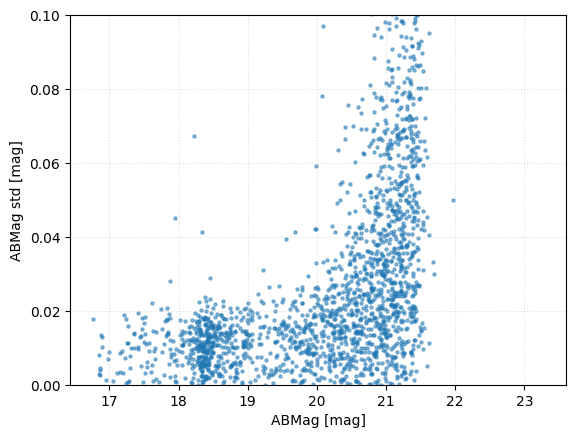

In [56]:
plt.scatter(res_cut['AB_mean'], res_cut['AB_std'], s=5, alpha=.5)
plt.ylim(0, .1)
plt.xlabel('ABMag [mag]')
plt.ylabel('ABMag std [mag]')
plt.grid(ls=':', alpha=.4)

Similarly the positions are measured down to ~0.01-0.015 pixels for the brighter stars, which is much more precise than typical star finding algorithms

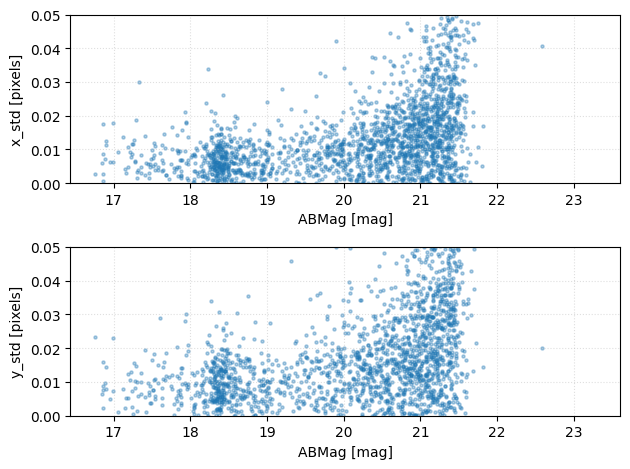

In [57]:
fig, axs = plt.subplots(2, 1)

axs[0].scatter(res_cut['AB_mean'], res_cut['x_std'], s=5, alpha=.35)
axs[0].set_ylim(0, .05)
axs[0].set_xlabel('ABMag [mag]')
axs[0].set_ylabel('x_std [pixels]')
axs[0].grid(ls=':', alpha=.4)

axs[1].scatter(res_cut['AB_mean'], res_cut['y_std'], s=5, alpha=.35)
axs[1].set_ylim(0, .05)
axs[1].set_xlabel('ABMag [mag]')
axs[1].set_ylabel('y_std [pixels]')
axs[1].grid(ls=':', alpha=.4)

plt.tight_layout()

Let's also take a look at the map of the RA/Decs for the sources and how often the sources were detected

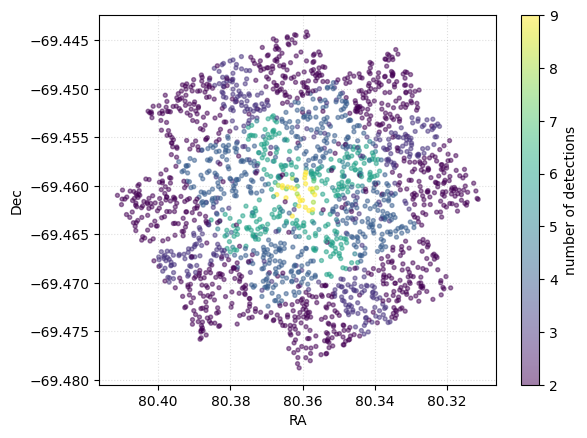

In [58]:
plt.scatter(res_cut['RA_mean'], res_cut['Dec_mean'], s=8, alpha=.5, c=res_cut['n'])
plt.xlabel('RA')
plt.xlim(plt.xlim()[::-1])
plt.ylabel('Dec')
cb = plt.colorbar()
cb.set_label('number of detections')
plt.grid(ls=':', alpha=.4)

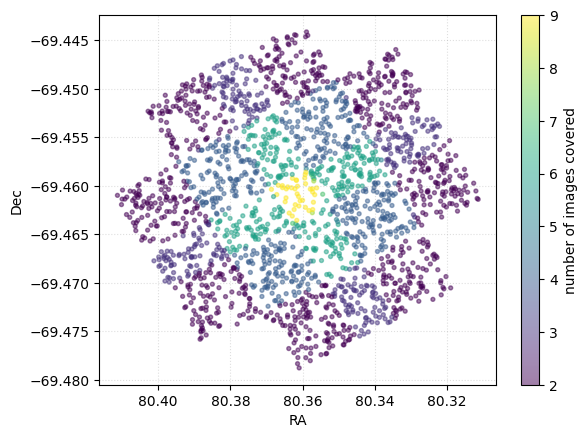

In [59]:
plt.scatter(res_cut['RA_mean'], res_cut['Dec_mean'], s=8, alpha=.5, c=res_cut['n_expected'])
plt.xlabel('RA')
plt.xlim(plt.xlim()[::-1])
plt.ylabel('Dec')
cb = plt.colorbar()
cb.set_label('number of images covered')
plt.grid(ls=':', alpha=.4)

***
### Saving as a master catalog

Lastly, we can save the merged catalog as a master catalog which can then be used to align other images!  We simply need to have an ecsv file containing RA/Dec columns.  We'll keep a few other columns in there, just so we can have some context for using it later. 

<div class="alert alert-block alert-warning">
<b>NOTE:</b> For the TweakRegStep, the dec column of the reference catalog has to be `DEC`.
</div>

In [60]:
master_cat = Table(res_cut['RA_mean', 'Dec_mean', 'q_mean', 'AB_mean', 'RA_std', 'Dec_std', 'AB_std', 'n', 'n_expected'],
                   names = ['RA', 'DEC', 'q_mean', 'AB_mean', 'RA_std', 'Dec_std', 'AB_std', 'n', 'n_expected']) 

To save it, we simply use the `write()` method of the Table.

In [63]:
master_cat.write(f'{filt}_master_cat.ecsv', overwrite=True)

## Conclusion

We hope this has been a good introduction to PSF photometry use cases.  Contributions and feedback are more than welcome, especially for other features and support for other instruments.  This package is still under heavy development, and so you may run into some bugs.  Do not hesitate to reach out to vbajaj@stsci.edu or open issues/PRs on github!

Also feel free to take a look at the documentation to see if there are other methods under the hood that might be useful for you!

<img style="float: center;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>